<a href="https://colab.research.google.com/github/Jefferson2325353/Taller_Distancias/blob/main/TallerDistancias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATA_DIR: /content/drive/MyDrive/Taller_Distancias/DatosDistancias 
 ['Datos Estaciones AMB.xlsx', 'mediciones_clg_normalsup_pm25_a_2018-11-01T00_00_00_2018-11-30T23_59_59.csv', 'mediciones_clg_normalsup_pm25_a_2018-12-01T00_00_00_2018-12-31T23_59_59.csv', 'mediciones_clg_normalsup_pm25_a_2019-01-01T00_00_00_2019-01-31T23_59_59.csv', 'mediciones_clg_normalsup_pm25_a_2019-08-01T00_00_00_2019-08-31T23_59_59.csv', 'mediciones_clg_normalsup_pm25_a_2019-07-01T00_00_00_2019-07-31T23_59_59.csv', 'mediciones_clg_normalsup_pm25_a_2019-06-01T00_00_00_2019-06-30T23_59_59.csv', 'mediciones_clg_normalsup_pm25_a_2019-05-01T00_00_00_2019-05-31T23_59_59.csv', 'mediciones_clg_normalsup_pm25_a_2019-04-01T00_00_00_2019-04-30T23_59_59.csv']
Patrón columnas: ['datetime', 'PM10', 'PM2.5', 'NO2 ppb', 'O3 ppb', 'Temp_Aire', 'Lluvia', 'Humedad_Relativa', 'WD', 'WS', 'R_Solar']
En Dat

/tmp/ipython-input-3809497892.py:32: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  out[tcol] = pd.to_datetime(out[tcol], errors="coerce", infer_datetime_format=True, dayfirst=dayfirst)
/tmp/ipython-input-3809497892.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  out[tcol] = pd.to_datetime(out[tcol], errors="coerce", infer_datetime_format=True, dayfirst=dayfirst)
/tmp/ipython-input-3809497892.py:153: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can

,datetime,y_sens,source
0,2018-11-03 23:32:49.639000+00:00,9.083333,mediciones_clg_normalsup_pm25_a_2018-11-01T00_...
1,2018-11-03 23:37:50.639000+00:00,9.083333,mediciones_clg_normalsup_pm25_a_2018-11-01T00_...
2,2018-11-03 23:42:50.639000+00:00,8.583334,mediciones_clg_normalsup_pm25_a_2018-11-01T00_...
3,2018-11-03 23:47:49.641000+00:00,8.666667,mediciones_clg_normalsup_pm25_a_2018-11-01T00_...
4,2018-11-03 23:52:49.638000+00:00,8.666666,mediciones_clg_normalsup_pm25_a_2018-11-01T00_...


Frecuencia base: 60min
Ventana 15 min → Distancia euclidiana = 548.42
Ventana 30 min → Distancia euclidiana = 548.42
Ventana 60 min → Distancia euclidiana = 548.42
Ventana 120 min → Distancia euclidiana = 516.86
Ventana 180 min → Distancia euclidiana = 497.44

▶ Ventana óptima: 180 min (dist = 497.44)
α (factor de calibración) = 0.5938
MAE = 3.06 | RMSE = 3.83


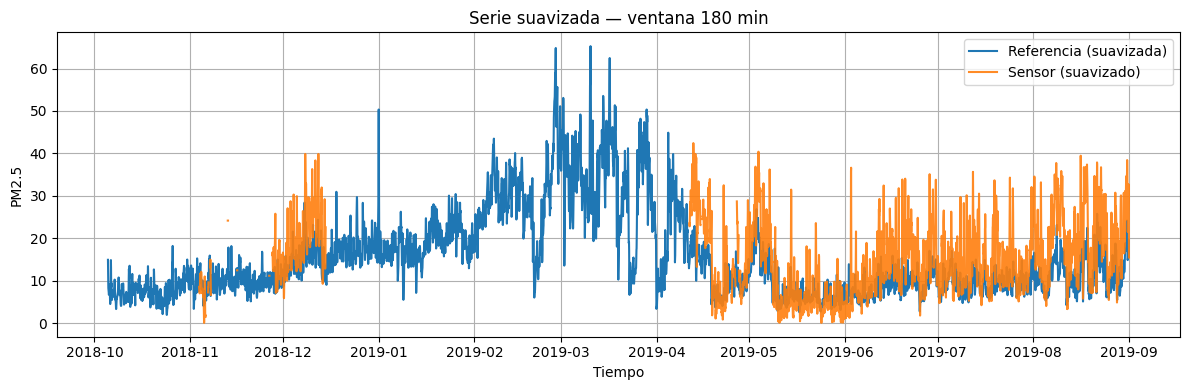

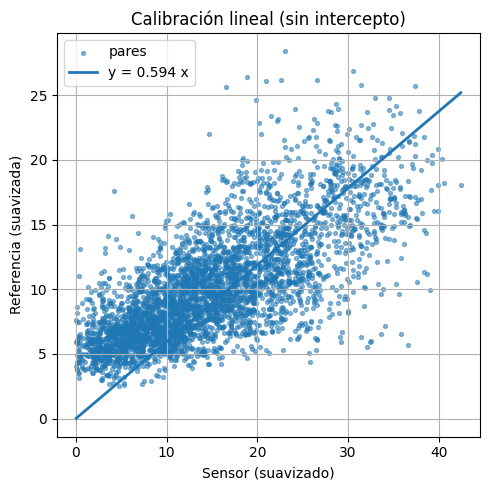

α entrenado (1ª mitad) = 0.6352
Train:  MAE=3.49, RMSE=4.31
Test :  MAE=2.68, RMSE=3.45
Puntos dentro de tolerancia: 81.8%
Rango válido (eje sensor suavizado): [0.03, 40.39]
Archivos guardados en: /content/drive/MyDrive/Taller_Distancias/resultados
✅ Resumen guardado en: /content/drive/MyDrive/Taller_Distancias/resultados/README_resumen.md


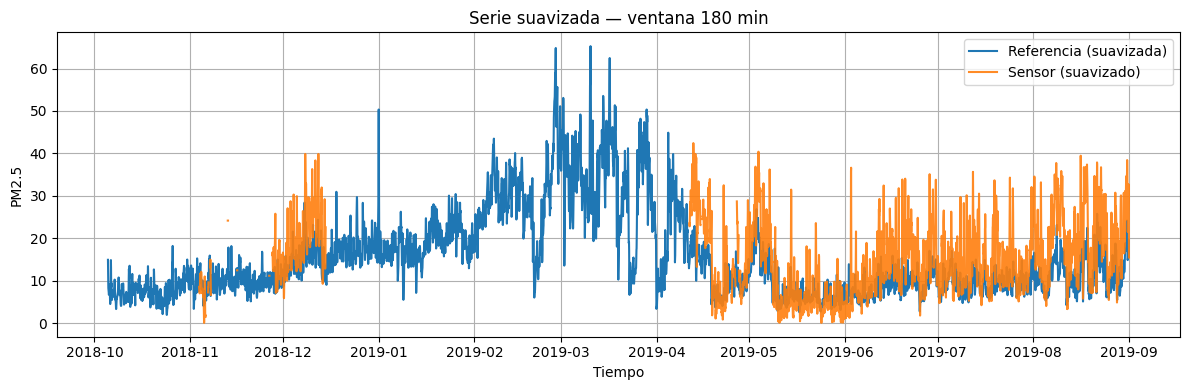

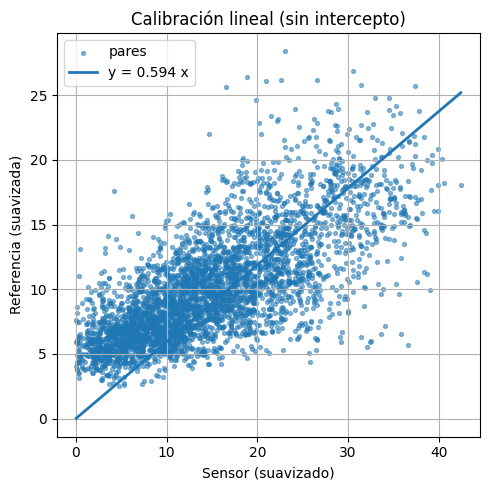

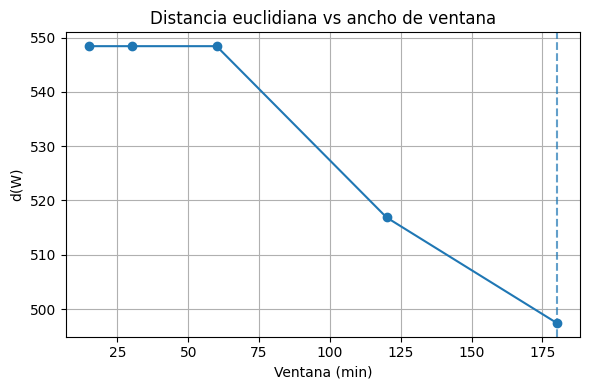

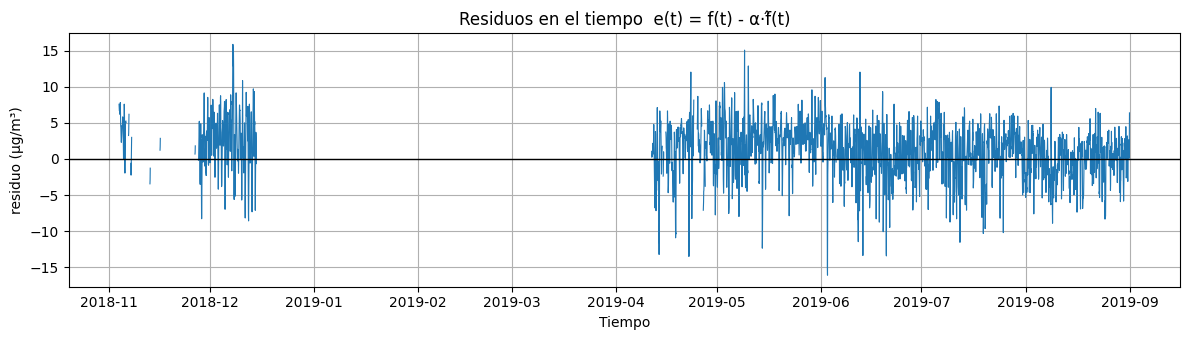

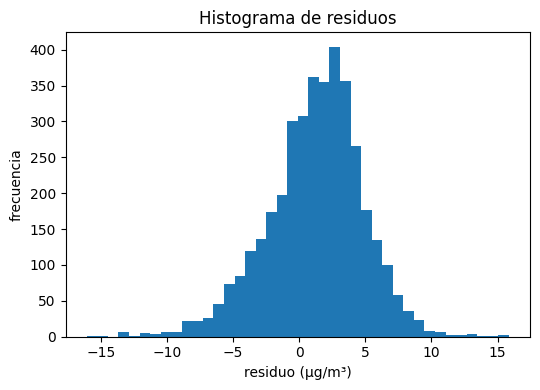

In [ ]:
# A) Montar y preparar rutas
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

from pathlib import Path
import os, pandas as pd, numpy as np

PROJECT  = "/content/drive/MyDrive/Taller_Distancias"
DATA_DIR = f"{PROJECT}/DatosDistancias"
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
print("DATA_DIR:", DATA_DIR, "\n", os.listdir(DATA_DIR))

# A1) Utilidades mínimas
def _canon(s):  # para detectar columna de tiempo tipo "Date&Time", "Fecha y Hora", etc.
    t = str(s).strip().lower()
    for ch in [" ", ".", "-", "/", "_", "&", ":"]:
        t = t.replace(ch, "")
    return t

def find_time_col(cols):
    m = {c:_canon(c) for c in cols}
    for c,k in m.items():
        if ("date" in k and "time" in k) or ("fecha" in k and "hora" in k) or k in {"datetime","fechahora"}:
            return c
    for c,k in m.items():
        if k in {"time","date","fecha","hora"}:
            return c
    raise ValueError(f"No encontré columna de tiempo. Columnas: {list(cols)}")

def coerce_datetime(df, tcol, dayfirst=True):
    out = df.copy()
    out[tcol] = pd.to_datetime(out[tcol], errors="coerce", infer_datetime_format=True, dayfirst=dayfirst)
    out = out.dropna(subset=[tcol]).rename(columns={tcol:"datetime"}).sort_values("datetime").reset_index(drop=True)
    return out

# A2) Leer Excel de referencia (PATRÓN)
EXCEL_FILE = f"{DATA_DIR}/Datos Estaciones AMB.xlsx"
SHEET      = 0            # o el nombre de tu hoja
PM_COL     = "PM2.5"      # <-- CAMBIA aquí si tu columna se llama distinto (ej: "PM 2.5")

ref_raw = pd.read_excel(EXCEL_FILE, sheet_name=SHEET)
tcol = find_time_col(ref_raw.columns)
ref_df = coerce_datetime(ref_raw, tcol)
# intentar convertir todas menos 'datetime' a numérico
for c in ref_df.columns:
    if c != "datetime":
        ref_df[c] = pd.to_numeric(ref_df[c], errors="coerce")
print("Patrón columnas:", list(ref_df.columns))
ref_df[["datetime", PM_COL]].head()



#B

# ====== CARGA ROBUSTA DE SENSORES (corregida para pandas 2.2) ======
import os, glob
import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = "/content/drive/MyDrive/Taller_Distancias/DatosDistancias"

# (1) listar
all_files = sorted(os.listdir(DATA_DIR))
print("En DatosDistancias hay:", len(all_files), "archivos")
for f in all_files:
    print(" -", f)

# patrón de tus archivos
csv_paths = sorted(glob.glob(f"{DATA_DIR}/mediciones*.csv"))
print("\nCandidatos CSV:", len(csv_paths))
for p in csv_paths[:5]:
    print(" >", Path(p).name)

# (2) lector robusto: SIN low_memory y con engine adaptativo
SEPS = [None, ",", ";", "\t", "|"]   # None => autodetección (engine='python')
ENCS = ["utf-8", "latin-1", "cp1252"]

def read_csv_robust(path):
    last_err = None
    for enc in ENCS:
        for sep in SEPS:
            try:
                # engine: 'python' solo cuando sep=None (autodetecta). Si no, usa 'c' (más rápido y estable)
                eng = "python" if sep is None else "c"
                df = pd.read_csv(path, sep=sep, engine=eng, encoding=enc)
                if df.shape[1] >= 2:
                    return df
            except Exception as e:
                last_err = e
    raise last_err if last_err else RuntimeError("No pude leer " + path)

# (3) detectores de columnas
def canon(s):
    s = str(s).strip().lower()
    for ch in [" ", ".", "-", "/", "_", "&", ":", "º"]:
        s = s.replace(ch, "")
    return s

def detect_time_col(df):
    # ya datetime
    for c in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[c]):
            return c
    # nombres típicos
    C = {c:canon(c) for c in df.columns}
    for c,k in C.items():
        if ("date" in k and "time" in k) or ("fecha" in k and "hora" in k) or k in {"datetime","fechahora"}:
            return c
    for c,k in C.items():
        if k in {"time","fecha","date","hora","timestamp"}:
            return c
    # prueba por conversión
    best_c, best_ok = None, -1
    for c in df.columns:
        try:
            t = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
            ok = t.notna().sum()
            if ok > best_ok:
                best_ok, best_c = ok, c
        except:
            pass
    if best_ok > 0: return best_c
    raise ValueError("No encontré columna de tiempo. Columnas: " + str(list(df.columns)))

def detect_value_col(df, exclude=()):
    C = {c:canon(c) for c in df.columns}
    for c,k in C.items():
        if c not in exclude and "pm25" in k:
            return c
    # primera numérica
    for c in df.columns:
        if c in exclude: continue
        if pd.api.types.is_numeric_dtype(df[c]):
            return c
    # convertible
    for c in df.columns:
        if c in exclude: continue
        try:
            pd.to_numeric(df[c], errors="raise")
            return c
        except:
            pass
    # último recurso
    for c in df.columns:
        if c not in exclude:
            return c

def clean_sensor_df(df):
    tcol = detect_time_col(df)
    ycol = detect_value_col(df, exclude=(tcol,))
    out = pd.DataFrame({
        "datetime": pd.to_datetime(df[tcol], errors="coerce", infer_datetime_format=True),
        "y_sens":   pd.to_numeric(df[ycol], errors="coerce"),
    }).dropna().sort_values("datetime").reset_index(drop=True)
    return out, tcol, ycol

# (4) cargar todos
sens_list, report = [], []
for p in csv_paths:
    try:
        raw = read_csv_robust(p)
        s, tcol, ycol = clean_sensor_df(raw)
        s["source"] = Path(p).name
        sens_list.append(s)
        report.append((Path(p).name, tcol, ycol, s.shape))
    except Exception as e:
        print("Saltando", Path(p).name, "→", e)

print("\nResumen detecciones (archivo, time_col, value_col, shape):")
for r in report[:10]:
    print(" ", r)

if len(sens_list) == 0:
    raise RuntimeError("❌ No pude cargar ningún CSV. Si persiste, cambia el patrón a '*.csv' o muéstrame el encabezado de un archivo.")

sensor = pd.concat(sens_list, ignore_index=True)\
          .drop_duplicates(subset="datetime")\
          .sort_values("datetime")
print("\n✅ Sensor unificado:", sensor.shape)
display(sensor.head())

#C


# ===== Celda C (REEMPLAZO) — ventanas + distancia + calibración + gráficas =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Timedelta
from pathlib import Path

PROJECT  = "/content/drive/MyDrive/Taller_Distancias"
FIGDIR   = f"{PROJECT}/figuras"
Path(FIGDIR).mkdir(parents=True, exist_ok=True)

# ---------- utilidades de tiempo ----------
def to_utc_naive(s):
    """Cualquier fecha -> UTC tz-aware -> quitar tz (naive)"""
    s = pd.to_datetime(s, errors="coerce", utc=True)
    return s.dt.tz_localize(None)

def ensure_naive(df, col="datetime"):
    df = df.copy()
    df[col] = to_utc_naive(df[col])
    return df

# Asegúrate de tener ref_df y sensor en memoria desde las celdas A y B
# Normalizamos AHORA mismo a UTC-naive
ref_df = ensure_naive(ref_df, "datetime")
sensor = ensure_naive(sensor, "datetime")

# Nombre de la columna de PM del Excel (ajústalo si es distinto)
PM_COL = PM_COL if "PM_COL" in globals() else "PM2.5"

# ---------- 1) Frecuencia base ----------
dt = ref_df["datetime"].sort_values().diff().dropna().median()
BASE_FREQ = f'{int(round(dt.total_seconds()/60))}min' if pd.notna(dt) else "15min"
print("Frecuencia base:", BASE_FREQ)

# ---------- 2) Helpers ----------
def resample_ma(df, tcol, ycol, freq, win_min):
    """Remuestrea y crea media móvil; fuerza datetime naive dentro de la función."""
    g = df[[tcol, ycol]].copy()
    g[tcol] = to_utc_naive(g[tcol])              # <- forzamos naive aquí también
    g = g.set_index(tcol).sort_index().resample(freq).median()
    step = pd.Timedelta(freq).total_seconds()/60
    w = max(1, int(round(win_min/step)))
    g[ycol + "_ma"] = g[ycol].rolling(w, center=True, min_periods=max(1, w//3)).mean()
    out = g.reset_index()
    out.rename(columns={out.columns[0]:"datetime"}, inplace=True)
    out["datetime"] = to_utc_naive(out["datetime"])  # <- y aquí de nuevo
    return out

def join_nearest(A, B, tol="20min"):
    """Antes de unir, garantizamos que ambas 'datetime' sean naive idénticas."""
    A = ensure_naive(A, "datetime")
    B = ensure_naive(B, "datetime")
    # Debug rápido (puedes comentar estas 2 líneas si quieres):
    # print("A dtype:", A["datetime"].dtype, "| B dtype:", B["datetime"].dtype)
    return pd.merge_asof(
        A.sort_values("datetime"), B.sort_values("datetime"),
        on="datetime", direction="nearest", tolerance=Timedelta(tol)
    )

def deuc(a, b):
    a, b = np.asarray(a, float), np.asarray(b, float)
    m = np.isfinite(a) & np.isfinite(b)
    return np.sqrt(((a[m]-b[m])**2).sum()) if m.any() else np.inf

def fit_alpha(x, y):
    x, y = np.asarray(x, float), np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 2: return np.nan
    den = (x[m]*x[m]).sum()
    return (x[m]*y[m]).sum()/den if den != 0 else np.nan

# ---------- 3) Barrido de ventanas (usar SOLO la columna *_ma) ----------
WINDOWS = [15, 30, 60, 120, 180]  # minutos
best = None

for W in WINDOWS:
    ref_tmp = resample_ma(ref_df, "datetime", PM_COL,   BASE_FREQ, W)
    ref_s   = ref_tmp[["datetime", f"{PM_COL}_ma"]].rename(columns={f"{PM_COL}_ma":"y_ref"})

    sen_tmp = resample_ma(sensor, "datetime", "y_sens", BASE_FREQ, W)
    sen_s   = sen_tmp[["datetime", "y_sens_ma"]].rename(columns={"y_sens_ma":"y_sens"})

    J = join_nearest(ref_s, sen_s, tol="20min")
    d = deuc(J["y_ref"], J["y_sens"])
    print(f"Ventana {W} min → Distancia euclidiana = {d:.2f}")

    if (best is None) or (d < best[0]):
        best = (d, W, J)

dist_opt, Wopt, Jopt = best
print(f"\n▶ Ventana óptima: {Wopt} min (dist = {dist_opt:.2f})")

# ---------- 4) Calibración ----------
alpha = fit_alpha(Jopt["y_sens"], Jopt["y_ref"])
print(f"α (factor de calibración) = {alpha:.4f}")

pred = alpha * Jopt["y_sens"].to_numpy()
yref = Jopt["y_ref"].to_numpy()
m = np.isfinite(pred) & np.isfinite(yref)
MAE  = np.mean(np.abs(yref[m]-pred[m]))
RMSE = np.sqrt(np.mean((yref[m]-pred[m])**2))
print(f"MAE = {MAE:.2f} | RMSE = {RMSE:.2f}")

# ---------- 5) Gráficas ----------
Path(FIGDIR).mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(12,4))
plt.plot(Jopt["datetime"], Jopt["y_ref"],  label="Referencia (suavizada)")
plt.plot(Jopt["datetime"], Jopt["y_sens"], label="Sensor (suavizado)", alpha=0.9)
plt.title(f"Serie suavizada — ventana {Wopt} min"); plt.xlabel("Tiempo"); plt.ylabel(PM_COL)
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig(f"{FIGDIR}/serie_win{Wopt}.png", dpi=150); plt.show()

plt.figure(figsize=(5,5))
plt.scatter(Jopt["y_sens"], Jopt["y_ref"], s=8, alpha=0.5, label="pares")
x = np.linspace(np.nanmin(Jopt["y_sens"]), np.nanmax(Jopt["y_sens"]), 200)
plt.plot(x, alpha*x, lw=2, label=f"y = {alpha:.3f} x")
plt.xlabel("Sensor (suavizado)"); plt.ylabel("Referencia (suavizada)")
plt.title("Calibración lineal (sin intercepto)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig(f"{FIGDIR}/calibracion_win{Wopt}.png", dpi=150); plt.show()

#D1

import numpy as np
import pandas as pd

def fit_alpha(x, y):
    x, y = np.asarray(x, float), np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 2: return np.nan
    den = (x[m]*x[m]).sum()
    return (x[m]*y[m]).sum()/den if den != 0 else np.nan

def validar_mitad_mitad(df_join):  # usa Jopt (join con ventana óptima)
    D = df_join.dropna(subset=["datetime","y_sens","y_ref"]).sort_values("datetime").reset_index(drop=True)
    n = len(D)
    mid = n // 2
    tr, te = D.iloc[:mid], D.iloc[mid:]
    a_tr = fit_alpha(tr["y_sens"], tr["y_ref"])
    pred_tr = a_tr * tr["y_sens"].to_numpy()
    pred_te = a_tr * te["y_sens"].to_numpy()
    y_tr, y_te = tr["y_ref"].to_numpy(), te["y_ref"].to_numpy()

    mae_tr  = np.mean(np.abs(y_tr - pred_tr))
    rmse_tr = np.sqrt(np.mean((y_tr - pred_tr)**2))
    mae_te  = np.mean(np.abs(y_te - pred_te))
    rmse_te = np.sqrt(np.mean((y_te - pred_te)**2))

    return a_tr, (mae_tr, rmse_tr), (mae_te, rmse_te)

a_tr, (mae_tr, rmse_tr), (mae_te, rmse_te) = validar_mitad_mitad(Jopt)
print(f"α entrenado (1ª mitad) = {a_tr:.4f}")
print(f"Train:  MAE={mae_tr:.2f}, RMSE={rmse_tr:.2f}")
print(f"Test :  MAE={mae_te:.2f}, RMSE={rmse_te:.2f}")


#D2

import numpy as np
import pandas as pd
from pathlib import Path

# ---- Define tu tolerancia
TOL_ABS = 5.0     # por ejemplo ±5 µg/m³
TOL_REL = None    # o por ejemplo 0.10 para ±10% (deja en None si usas absoluta)

def rango_validez(df_join, alpha, tol_abs=None, tol_rel=None):
    D = df_join.dropna(subset=["y_sens","y_ref"]).copy()
    pred = alpha * D["y_sens"].to_numpy()
    err  = np.abs(D["y_ref"].to_numpy() - pred)

    if tol_abs is not None:
        ok = err <= tol_abs
    elif tol_rel is not None:
        ok = err <= tol_rel * np.maximum(np.abs(D["y_ref"].to_numpy()), 1e-12)
    else:
        raise ValueError("Define tol_abs o tol_rel")

    D["ok_tol"] = ok
    porc_ok = 100 * ok.mean()
    if ok.any():
        x_min = float(D.loc[ok, "y_sens"].min())
        x_max = float(D.loc[ok, "y_sens"].max())
    else:
        x_min = x_max = np.nan
    return D, porc_ok, (x_min, x_max)

Dtol, porc_ok, (x_min, x_max) = rango_validez(Jopt, alpha, tol_abs=TOL_ABS, tol_rel=TOL_REL)
print(f"Puntos dentro de tolerancia: {porc_ok:.1f}%")
print(f"Rango válido (eje sensor suavizado): [{x_min:.2f}, {x_max:.2f}]")

# ---- Exportar resultados resumidos
PROJECT  = "/content/drive/MyDrive/Taller_Distancias"
OUTDIR   = f"{PROJECT}/resultados"; Path(OUTDIR).mkdir(parents=True, exist_ok=True)

resumen = pd.DataFrame({
    "ventana_min":[Wopt],
    "dist_euclidiana":[float(dist_opt)],
    "alpha":[float(alpha)],
    "MAE_global":[float(MAE)],
    "RMSE_global":[float(RMSE)],
    "alpha_train_half":[float(a_tr)],
    "MAE_train":[float(mae_tr)],
    "RMSE_train":[float(rmse_tr)],
    "MAE_test":[float(mae_te)],
    "RMSE_test":[float(rmse_te)],
    "tolerancia_abs":[TOL_ABS],
    "tolerancia_rel":[TOL_REL if TOL_REL is not None else np.nan],
    "porc_ok_tol":[float(porc_ok)],
    "x_valid_min":[x_min],
    "x_valid_max":[x_max],
})
resumen.to_csv(f"{OUTDIR}/resumen_taller.csv", index=False)
Jopt.to_csv(f"{OUTDIR}/pares_suavizados_join.csv", index=False)
Dtol.to_csv(f"{OUTDIR}/pares_con_tolerancia.csv", index=False)
print("Archivos guardados en:", OUTDIR)

#Mini-reporte en Markdown

from pathlib import Path

PROJECT  = "/content/drive/MyDrive/Taller_Distancias"
OUTDIR   = f"{PROJECT}/resultados"
FIGDIR   = f"{PROJECT}/figuras"
Path(OUTDIR).mkdir(parents=True, exist_ok=True)

md = f"""# Taller de Distancias — Resumen

**Ventana óptima:** {Wopt} min
**Distancia (mínima):** {dist_opt:.2f}

**α (calibración sin intercepto):** {alpha:.4f}
**MAE global:** {MAE:.2f}
**RMSE global:** {RMSE:.2f}

**Validación mitad/mitad**
- α entrenado (1ª mitad): {a_tr:.4f}
- Train: MAE={mae_tr:.2f}, RMSE={rmse_tr:.2f}
- Test:  MAE={mae_te:.2f}, RMSE={rmse_te:.2f}

**Tolerancia:** ±{TOL_ABS if TOL_REL is None else f'{100*TOL_REL:.0f}%'}
**% dentro de tolerancia:** {porc_ok:.1f}%
**Rango válido (eje sensor suavizado):** [{x_min:.2f}, {x_max:.2f}]

**Figuras:**
- Serie suavizada: `{FIGDIR}/serie_win{Wopt}.png`
- Calibración: `{FIGDIR}/calibracion_win{Wopt}.png`

**Datos:**
- Pares suavizados: `{OUTDIR}/pares_suavizados_join.csv`
- Puntos con tolerancia: `{OUTDIR}/pares_con_tolerancia.csv`
- Resumen: `{OUTDIR}/resumen_taller.csv`
"""

with open(f"{OUTDIR}/README_resumen.md", "w", encoding="utf-8") as f:
    f.write(md)

print("✅ Resumen guardado en:", f"{OUTDIR}/README_resumen.md")


#figuras

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FIGDIR = f"{PROJECT}/figuras"
Path(FIGDIR).mkdir(parents=True, exist_ok=True)

# 1) Serie temporal suavizada
plt.figure(figsize=(12,4))
plt.plot(Jopt["datetime"], Jopt["y_ref"],  label="Referencia (suavizada)")
plt.plot(Jopt["datetime"], Jopt["y_sens"], label="Sensor (suavizado)", alpha=0.9)
plt.title(f"Serie suavizada — ventana {Wopt} min"); plt.xlabel("Tiempo"); plt.ylabel("PM2.5")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig(f"{FIGDIR}/serie_win{Wopt}.png", dpi=150); plt.show()

# 2) Calibración (dispersión + recta y = α x)
plt.figure(figsize=(5,5))
plt.scatter(Jopt["y_sens"], Jopt["y_ref"], s=8, alpha=0.5, label="pares")
x = np.linspace(np.nanmin(Jopt["y_sens"]), np.nanmax(Jopt["y_sens"]), 200)
plt.plot(x, alpha*x, lw=2, label=f"y = {alpha:.3f} x")
plt.xlabel("Sensor (suavizado)"); plt.ylabel("Referencia (suavizada)")
plt.title("Calibración lineal (sin intercepto)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig(f"{FIGDIR}/calibracion_win{Wopt}.png", dpi=150); plt.show()

# 3) Curva d(W) vs W  (si no guardaste las distancias, las recomputamos rápido)
WINDOWS = [15, 30, 60, 120, 180]      # usa la misma lista que usaste antes
dists = []
for W in WINDOWS:
    ref_tmp = resample_ma(ref_df, "datetime", PM_COL,   BASE_FREQ, W)
    ref_s   = ref_tmp[["datetime", f"{PM_COL}_ma"]].rename(columns={f"{PM_COL}_ma":"y_ref"})
    sen_tmp = resample_ma(sensor, "datetime", "y_sens", BASE_FREQ, W)
    sen_s   = sen_tmp[["datetime", "y_sens_ma"]].rename(columns={"y_sens_ma":"y_sens"})
    J = join_nearest(ref_s, sen_s, tol="20min")
    d = deuc(J["y_ref"], J["y_sens"])
    dists.append(d)

plt.figure(figsize=(6,4))
plt.plot(WINDOWS, dists, marker="o")
plt.axvline(Wopt, ls="--", alpha=0.7)
plt.title("Distancia euclidiana vs ancho de ventana")
plt.xlabel("Ventana (min)"); plt.ylabel("d(W)")
plt.grid(True); plt.tight_layout()
plt.savefig(f"{FIGDIR}/ventana_vs_distancia.png", dpi=150); plt.show()

# 4) Residuos en el tiempo
e = Jopt["y_ref"].to_numpy() - alpha * Jopt["y_sens"].to_numpy()
plt.figure(figsize=(12,3.5))
plt.plot(Jopt["datetime"], e, lw=0.8)
plt.axhline(0, color="k", lw=1)
plt.title("Residuos en el tiempo  e(t) = f(t) - α·f̂(t)")
plt.xlabel("Tiempo"); plt.ylabel("residuo (µg/m³)")
plt.grid(True); plt.tight_layout()
plt.savefig(f"{FIGDIR}/residuos_tiempo.png", dpi=150); plt.show()

# 5) Histograma de residuos
plt.figure(figsize=(5.5,4))
plt.hist(e[np.isfinite(e)], bins=40)
plt.title("Histograma de residuos")
plt.xlabel("residuo (µg/m³)"); plt.ylabel("frecuencia")
plt.tight_layout()
plt.savefig(f"{FIGDIR}/hist_residuos.png", dpi=150); plt.show()


